<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [56]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [57]:
df=pd.read_csv('/datasets/taxi.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [58]:
df['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

In [59]:
df.duplicated().value_counts()

False    26496
dtype: int64

In [60]:
df[df['num_orders']==0].count()

datetime      537
num_orders    537
dtype: int64

Проблем с данными незаметно - полных дубликатов нет, пропусков тоже. Аномальных значений не заметно (заказы такси в аэропорту могут сильно "скакать" с прибытием больших самолетов). Возможно слишком много строк с 0 заказов, однако промежутки в 10 минут достаточно малы, чтобы такое было возможно. Перейдем к ресемплированию.

In [61]:
df['datetime']=df['datetime'].astype('datetime64')
df=df.set_index('datetime').sort_index()

In [62]:
df = df.resample('1H').sum()

## Анализ

Text(0.5, 1.0, 'Сезонность')

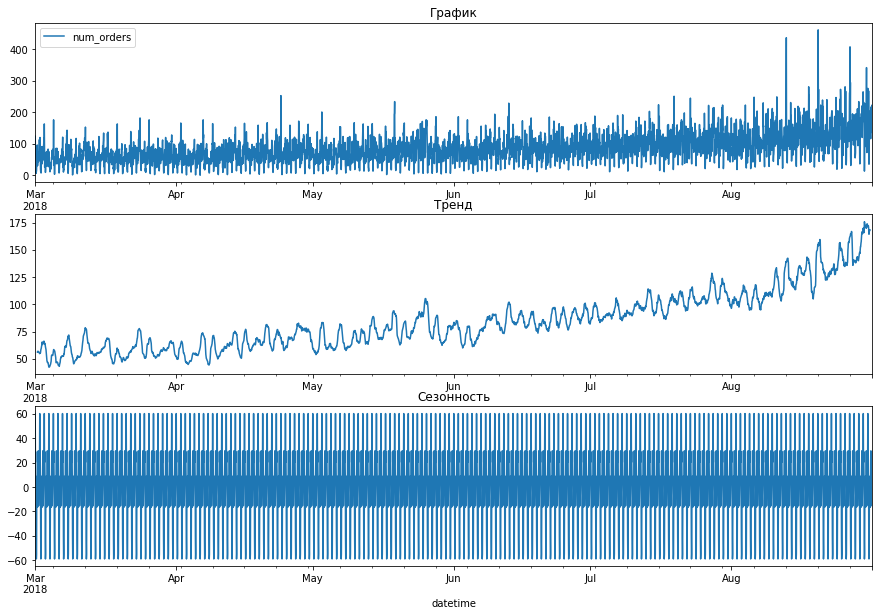

In [63]:
decomposed = seasonal_decompose(df) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Text(0.5, 1.0, 'Сезонность')

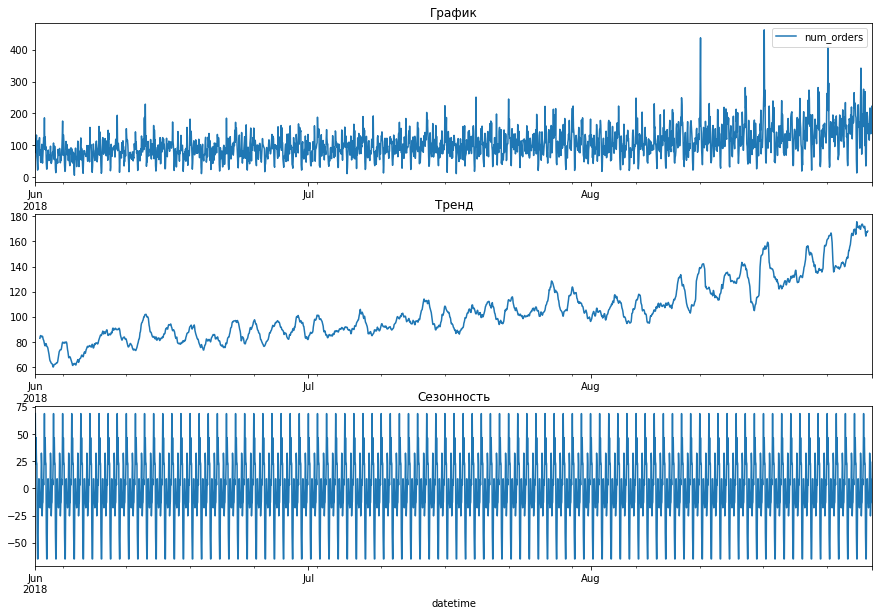

In [64]:
#посмотрим на последние 3 месяца
df2=df['2018-06':'2018-09']
decomposed2 = seasonal_decompose(df2) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df2.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed2.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Text(0.5, 1.0, 'Сезонность')

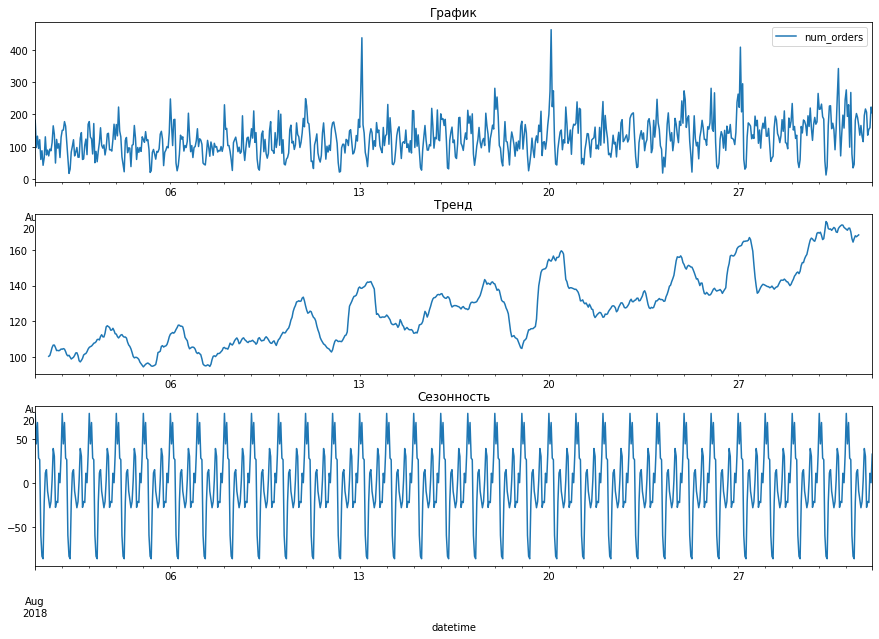

In [65]:
#посмотрим только на август
df3=df['2018-08':'2018-09']
decomposed3 = seasonal_decompose(df3) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df3.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed3.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed3.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Text(0.5, 1.0, 'Сезонность')

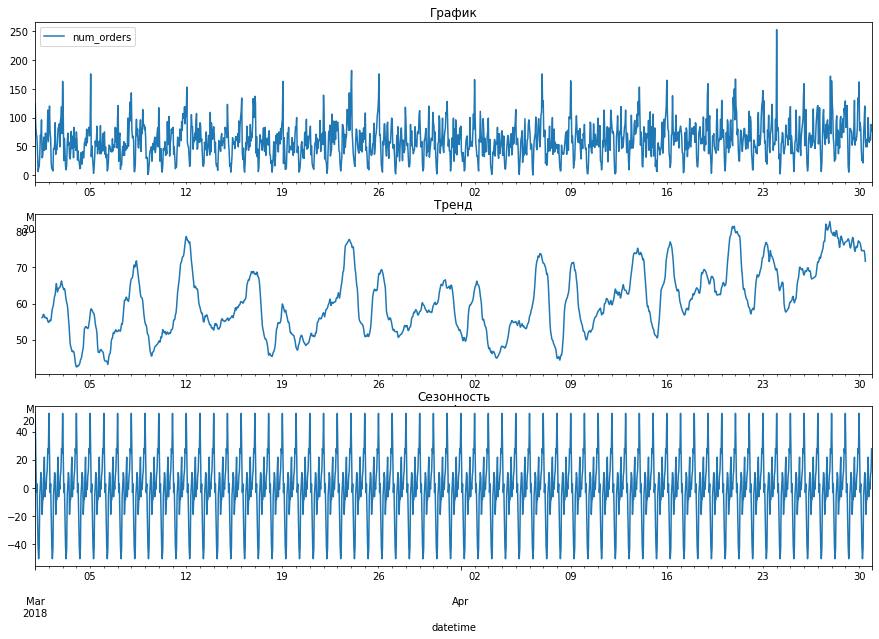

In [66]:
#посмотрим только на март
df4=df['2018-03':'2018-04']
decomposed4 = seasonal_decompose(df4) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df4.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed4.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed4.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Text(0.5, 1.0, 'Разбивка в 3 дня')

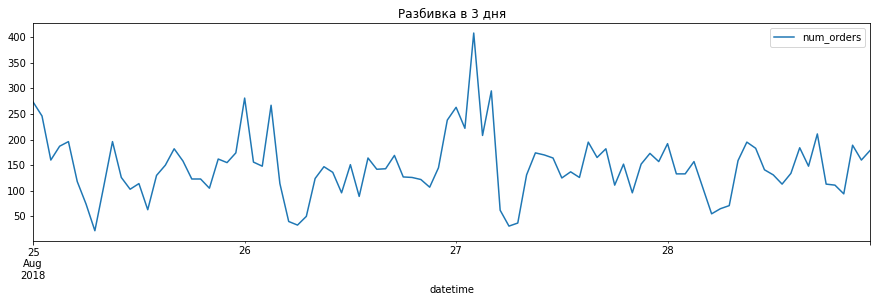

In [67]:
df['2018-08-25':'2018-08-28'].plot(figsize=(15, 4))
plt.title('Разбивка в 3 дня')

В любой разбивке тренд растет - неудивительно, летний период - период отпусков, люди чаще летают заграницу. Также везде наблюдается сезонность - ближе к полуночи заказов больше (либо большинство рейсов прилетают в это время, либо люди чаще выбирают такси, т.к. добраться на другом транспорте ночью сложнее). Также присутствует заметные выбросы на графике, особенно в августе. Скорее всего они связаны с окончанием отпусков (люди прилетают в ночь перед первым рабочим днем после отпуска).

In [68]:
df_day = df.resample('1D').sum()

Text(0.5, 1.0, 'Сезонность')

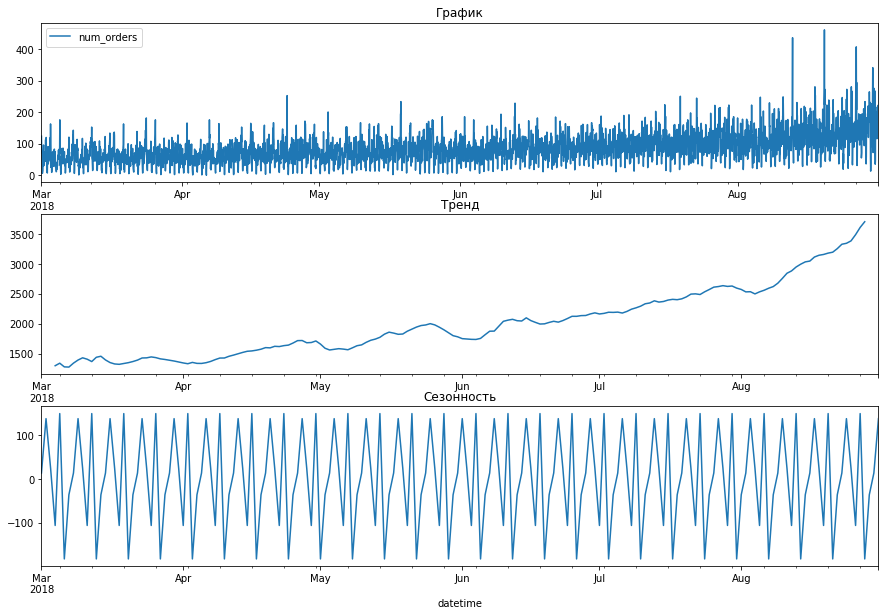

In [69]:
decomposed_day = seasonal_decompose(df_day) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Text(0.5, 1.0, 'Сезонность')

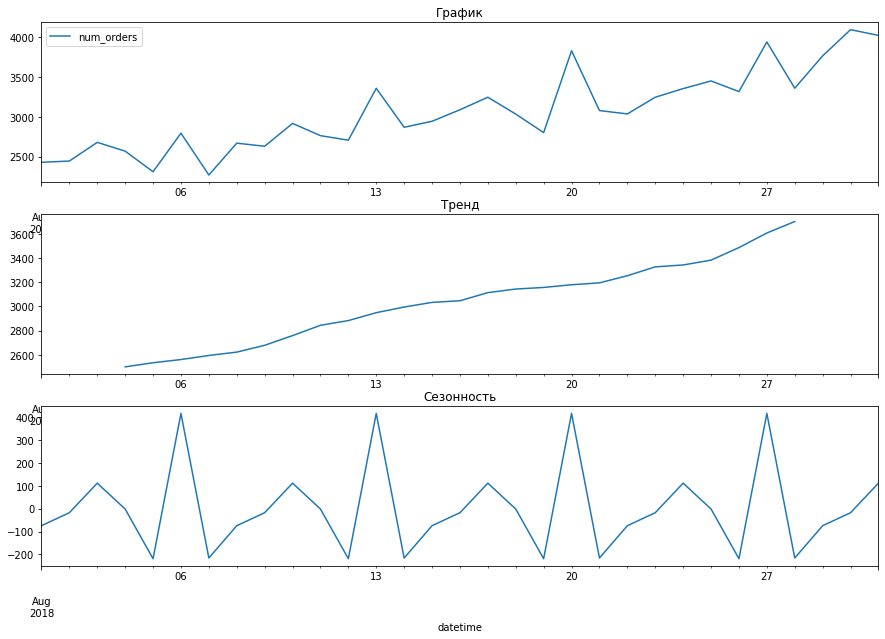

In [70]:
df_day2=df_day['2018-08':'2018-09']
decomposed_day2 = seasonal_decompose(df_day2) 
plt.figure(figsize=(15, 10))
plt.subplot(311)
df_day2.plot(ax=plt.gca())
plt.title('График')
plt.subplot(312)
decomposed_day2.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed_day2.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

Недельная сезонность приходится на ночь с воскресенья на понедельник, в меньшей степени на ночь пятница-суббота.

## Обучение

Создадим признаки для обучения модели. Из календарных признаков нам нужны: месяц, день, день недели. Год один и тот же, в этом признаке смысла нет. Для предсказания тренда добавим отстающие значения и скользящее среднее. 

In [71]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [72]:
make_features(df, 24, 5)

In [73]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [74]:
df.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4416, freq='H')

In [75]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
round(np.mean(-score_lr)**0.5, 2)

27.99

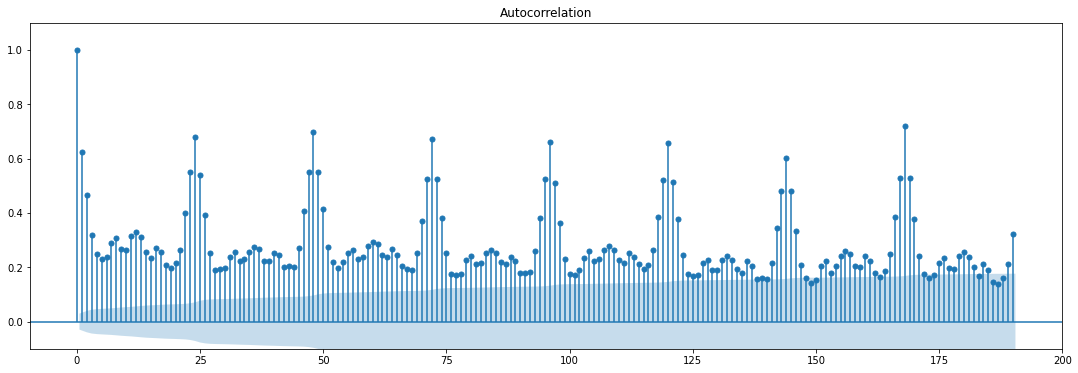

In [2]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

In [78]:
model_rfr = RandomForestRegressor(random_state=12345)
model_rfr.fit(features_train, target_train)
parameters = {'n_estimators' : sp_randInt(1, 50), 'max_depth' : sp_randInt(1, 10)
              , 'max_features' : sp_randInt(1, 5), 'min_samples_leaf' : sp_randInt(1, 5)}
tscv = TimeSeriesSplit(n_splits=5)
randm_src = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=tscv)
randm_src.fit(features_train, target_train)
randm_src.best_params_

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 48}

In [85]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_rfr = RandomForestRegressor(random_state=12345, n_estimators=48, max_depth=8, max_features=3, min_samples_leaf=1)

model_rfr.fit(features_train, target_train)
score_rfr = cross_val_score(model_rfr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
round(np.mean(-score_rfr)**0.5, 2)

29.62

In [87]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_cb = CatBoostRegressor(iterations=1000,
                           eval_metric='RMSE',
                           max_leaves = 31,
                           learning_rate = 0.1,
                           verbose=100)
model_cb.fit(features_train, target_train)
score_cb = cross_val_score(model_cb, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
round(np.mean(-score_cb)**0.5, 2)

0:	learn: 36.7902119	total: 7.42ms	remaining: 7.42s
100:	learn: 19.8540182	total: 776ms	remaining: 6.91s
200:	learn: 16.3145247	total: 1.55s	remaining: 6.16s
300:	learn: 14.0229771	total: 2.31s	remaining: 5.37s
400:	learn: 12.3957347	total: 3.13s	remaining: 4.68s
500:	learn: 10.9609025	total: 3.86s	remaining: 3.84s
600:	learn: 9.8128539	total: 4.59s	remaining: 3.04s
700:	learn: 8.7757317	total: 5.32s	remaining: 2.27s
800:	learn: 7.8333564	total: 6.13s	remaining: 1.52s
900:	learn: 7.0592415	total: 6.91s	remaining: 760ms
999:	learn: 6.3867894	total: 7.65s	remaining: 0us
0:	learn: 28.0685344	total: 5.34ms	remaining: 5.34s
100:	learn: 12.1941823	total: 438ms	remaining: 3.9s
200:	learn: 8.0803798	total: 919ms	remaining: 3.65s
300:	learn: 5.6403668	total: 1.38s	remaining: 3.2s
400:	learn: 4.0175141	total: 1.8s	remaining: 2.7s
500:	learn: 2.8017537	total: 2.24s	remaining: 2.23s
600:	learn: 2.0419355	total: 2.66s	remaining: 1.77s
700:	learn: 1.4476121	total: 3.14s	remaining: 1.34s
800:	learn: 

26.13

Лучше всего себя показала модель CatBoost, протестируем ее. Однако, ее обучение занимает достаточно много времени - протестируем еще линейную регрессию, она намного быстрее.

## Тестирование

In [88]:
%%time
predictions_test = model_cb.predict(features_test)
mean_squared_error(target_test, predictions_test, squared=False)

CPU times: user 957 µs, sys: 7.96 ms, total: 8.91 ms
Wall time: 5.95 ms


40.516619226733056

In [89]:
%%time
predictions_test = model_lr.predict(features_test)
mean_squared_error(target_test, predictions_test, squared=False)

CPU times: user 0 ns, sys: 11.3 ms, total: 11.3 ms
Wall time: 3.46 ms


45.16859297010217

In [90]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
mean_squared_error(target_test, pred_previous, squared=False)

58.856486242815066

Обе модели проходят порог и могут быть использованы. Обе модели также значительно лучше константной. Т.к. в задаче ничего не сказано про скорость обучения, возьмем CatBoost как лучшую модель. 

## Вывод

В ходе работы данные были загружены и проанализированы, аномалий не обнаружено. Был проведен анализ данных - установлена сезонность (повышение кол-ва заказов ближе к полуночи, концентрация в ночь с воскресенье на понедельник), установлен тренд на рост кол-ва заказов в связи с летним сезоном. Было обучено 3 модели, из них выбрана лучшая - CatBoost со следующими параметрами: iterations=1000, max_leaves = 31, learning_rate = 0.1